In [1]:
import sys
sys.path.append('/kaggle/input/pretrainedmodels/pretrainedmodels-0.7.4')
sys.path.append('/kaggle/input/efficientnet-pytorch/EfficientNet-PyTorch-master')
sys.path.append('/kaggle/input/timm-pytorch-image-models/pytorch-image-models-master')
sys.path.append('/kaggle/input/segmentation-models-pytorch/segmentation_models.pytorch-master')


In [2]:
import os
import shutil
import warnings
from glob import glob
import gc
import random
import sys

import cv2
import PIL.Image as Image
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.ndimage import gaussian_filter
from scipy import ndimage
import torch
import torch.nn as nn
import segmentation_models_pytorch as smp
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm

warnings.simplefilter("ignore")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
is_kaggle_notebook = "kaggle_web_client" in sys.modules

## config

In [22]:
class CFG:

    # ============== comp exp name =============
    comp_name = 'vesuvius'
    comp_dir_path = '/kaggle/input/'
    comp_folder_name = 'vesuvius-challenge-ink-detection'

    prefix = "nonflatten"  # "flatten" "non_flatten"
    start = 29
    stop = 34
    input_dirs = f"/kaggle/input/vesuvius-challenge-ink-detection/test/"
    stack_dir = f"/kaggle/working/dataset_inference/"
    save_dir = f"/kaggle/working/dataset_inference/{prefix}/"
    comp_dataset_path = f"/kaggle/working/dataset_inference/{prefix}/{start}-{stop}/"

    exp_name = "model23"
    TH = 0.45
    fold = 5

    # ============== model cfg =============
    model_name = 'UnetPlusPlus'
    backbone = 'se_resnext50_32x4d'
    in_chans = 6

    # ============== pred target =============
    target_size = 1
    TTA=True
    # ============== training cfg =============
    size = 224
    tile_size = 224
    stride = tile_size // 4

    valid_batch_size = 16  # 32
    use_amp = True

    # ============== fixed =============
    num_workers = 4

    # ============== augmentation =============
    valid_aug_list = [
        A.Resize(size, size),
        A.Normalize(
            mean=[0] * in_chans,
            std=[1] * in_chans,
            max_pixel_value=65535,
        ),
        ToTensorV2(transpose_mask=True),
    ]


## preprocess

In [23]:
from os import path
from tqdm import tqdm
import matplotlib.pyplot as plt
import PIL.Image as Image
import numpy as np
from scipy import ndimage
from scipy.ndimage import gaussian_filter
import shutil
import gc
import os
import cv2
from glob import glob
GAUSSIAN_BLUR_TOPOGRAPHIC_MAP = False


def split_label_mask_train(input_dir, dataset_dir, split):
    fragment_i = input_dir.split("/")[-1]
    for split_i in range(split):
        mask = cv2.imread(f"{input_dir}/mask.png", 0)
        label = cv2.imread(f"{input_dir}/inklabels.png", 0)
        image_height = mask.shape[0]
        split_height = image_height // split
        if split_i == split - 1:
            mask = mask[split_i * split_height: image_height, :]
            label = label[split_i * split_height: image_height, :]
        else:
            mask = mask[split_i * split_height: (split_i + 1) * split_height, :]
            label = label[split_i * split_height: (split_i + 1) * split_height, :]

        topography = cv2.imread(f"{dataset_dir}/topography_{fragment_i}_{split_i}.png", 0)
        sea = np.where(topography == 0, 255, 0).astype("uint8")
        label_modified = label-cv2.bitwise_and(sea, label)

        cv2.imwrite(dataset_dir + f"mask_{fragment_i}_{split_i}.png", mask)
        cv2.imwrite(dataset_dir + f"inklabels_{fragment_i}_{split_i}.png", label_modified)


def split_label_mask_inference(input_dir, dataset_dir, fragment_i):
    shutil.copy(f"{input_dir}/mask.png", dataset_dir + f"mask_{fragment_i}.png")


def split_stack_image(input_dir, dataset_dir, split=1):
    fragment_i = input_dir.split("/")[-1]
    image_height = cv2.imread(f"{input_dir}/surface_volume/01.tif", -1).shape[0]
    split_height = image_height // split

    for split_i in range(split):
        image_stack = None
        images = []

        surfaces_path = sorted(glob(f"{input_dir}/surface_volume/*.tif"))
        save_npy_path = dataset_dir + f"image_stack_{fragment_i}_{split_i}.npy"
        if os.path.exists(save_npy_path):
            continue

        for surface_path in tqdm(surfaces_path):
            image = cv2.imread(surface_path, -1)
            if split_i < split - 1:
                image = image[split_i * split_height: (split_i + 1) * split_height, :]
            else:
                image = image[split_i * split_height: image_height, :]
            images.append(image)
            del image
        image_stack = np.stack(images)

        del images
        gc.collect()

        with open(save_npy_path, "wb") as f:
            np.save(f, image_stack, allow_pickle=True)
        del image_stack
        gc.collect()


def extract_nonflatten_layers(input_dir, save_dir, fragment_i, split_i, start, stop, delete=False):
    input_stack_path = f"{input_dir}/image_stack_{fragment_i}_{split_i}.npy"
    output_stack_path = f"{save_dir}/{fragment_i}_{split_i}.npy"

    if os.path.exists(output_stack_path):
        return

    stack = np.load(open(input_stack_path, "rb"))
    stack = stack[start: stop + 1, :, :]

    with open(output_stack_path, "wb") as f:
        np.save(f, stack, allow_pickle=True)
    del stack
    gc.collect()

    if delete:
        os.remove(os.path.join(input_stack_path))


def concat_npy(save_dir, start, stop, fragment_i, delete=False):
    npy_list = []
    for npy in sorted(glob(f"{save_dir}/{fragment_i}_*.npy")):
        npy_list.append(np.load(open(npy, 'rb')))
        if delete:
            os.remove(npy)
    result = np.concatenate(npy_list, axis=1)
    output_stack_fname = f"{fragment_i}.npy"
    with open(f"{save_dir}/{output_stack_fname}", 'wb') as f:
        np.save(f, result, allow_pickle=True)


def dataset_preprocess_nonflatten(input_dir, dataset_dir, split, start, stop, train=True, delete=True):
    image_stack_dir = f"{dataset_dir}/nonflatten/"
    extract_save_dir = f"{image_stack_dir}/{start}-{stop}/"
    os.makedirs(dataset_dir, exist_ok=True)
    os.makedirs(image_stack_dir, exist_ok=True)
    os.makedirs(extract_save_dir, exist_ok=True)

    fragment_i = input_dir.split("/")[-1]
    print(input_dir)
    if train:
        split_label_mask_train(input_dir, dataset_dir, split)
    else:
        split_label_mask_inference(input_dir, dataset_dir, fragment_i)

    split_stack_image(input_dir, dataset_dir, split)

    for split_i in range(split):
        extract_nonflatten_layers(dataset_dir, extract_save_dir, fragment_i, split_i, start, stop, delete)

    if not train:
        concat_npy(extract_save_dir, start, stop, fragment_i, delete)


In [24]:
if is_kaggle_notebook:
    split=3
    delete=True
else:
    split=1
    delete=False

for input_dir in glob(f"{CFG.input_dirs}/*"):
    dataset_preprocess_nonflatten(f"{input_dir}", CFG.stack_dir, split, 29, 34, train=False, delete=delete)


/kaggle/input/vesuvius-challenge-ink-detection/test/a
/kaggle/input/vesuvius-challenge-ink-detection/test/b


## helper

In [25]:
# ref.: https://www.kaggle.com/stainsby/fast-tested-rle
def rle(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.flatten()
    # pixels = (pixels >= thr).astype(int)

    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)


## dataset

In [26]:
def preprocess(image):
    # image=np.clip(image, a_min=0.15,a_max=0.7)
    return image


In [27]:
def read_image(fragment_id):
    image_stack = np.load(open(f"{CFG.comp_dataset_path}/{fragment_id}.npy", 'rb'))

    pad0 = (CFG.tile_size - image_stack.shape[1] % CFG.tile_size)
    pad1 = (CFG.tile_size - image_stack.shape[2] % CFG.tile_size)

    image_stack = np.pad(image_stack, [(0, 0), (0, pad0), (0, pad1)], constant_values=0)
    image_stack = image_stack.transpose((1, 2, 0))
    image_stack = preprocess(image_stack)

    return image_stack

def get_transforms(data, cfg):
    if data == 'train':
        aug = A.Compose(cfg.train_aug_list)
    elif data == 'valid':
        aug = A.Compose(cfg.valid_aug_list)

    # print(aug)
    return aug


class CustomDataset(Dataset):
    def __init__(self, images, cfg, labels=None, transform=None):
        self.images = images
        self.cfg = cfg
        self.labels = labels
        self.transform = transform

    def __len__(self):
        # return len(self.xyxys)
        return len(self.images)

    def __getitem__(self, idx):
        # x1, y1, x2, y2 = self.xyxys[idx]
        image = self.images[idx]
        data = self.transform(image=image)
        image = data['image']
        return image

def make_test_dataset(fragment_id):
    test_images = read_image(fragment_id)
    x1_list = list(range(0, test_images.shape[1]-CFG.tile_size+1, CFG.stride))
    y1_list = list(range(0, test_images.shape[0]-CFG.tile_size+1, CFG.stride))

    test_images_list = []
    xyxys = []
    for y1 in y1_list:
        for x1 in x1_list:
            y2 = y1 + CFG.tile_size
            x2 = x1 + CFG.tile_size

            test_images_list.append(test_images[y1:y2, x1:x2])
            xyxys.append((x1, y1, x2, y2))
    # xyxys = np.stack(xyxys)

    test_dataset = CustomDataset(test_images_list, CFG, transform=get_transforms(data='valid', cfg=CFG))

    test_loader = DataLoader(test_dataset,
                             batch_size=CFG.valid_batch_size,
                             shuffle=False,
                             num_workers=CFG.num_workers, pin_memory=True, drop_last=False)
    # return test_images_list
    return test_loader, xyxys


uint16
(2912, 6496, 6)
65535


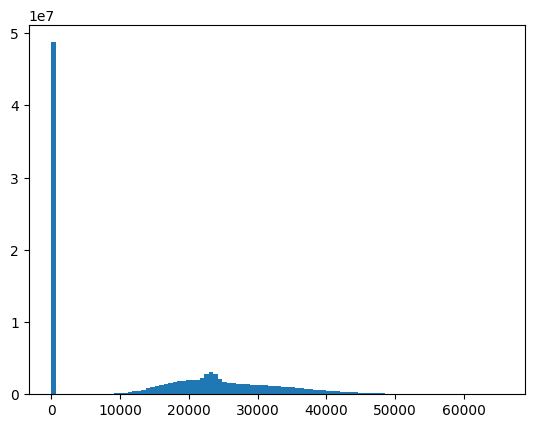

In [28]:
image = read_image("a")
print(image.dtype)
print(image.shape)
print(image.max())
plt.hist(image.flatten(), bins=100);


torch.Size([16, 6, 224, 224])


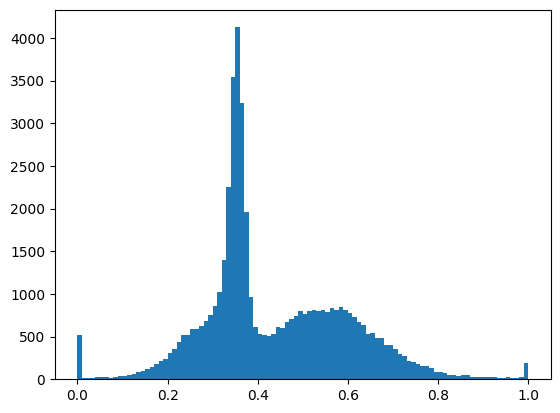

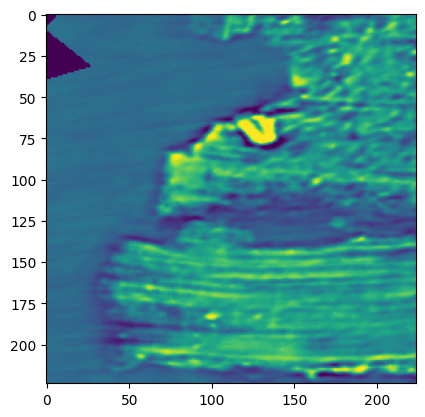

In [29]:
for i, image in enumerate((make_test_dataset("a")[0])):
    if i != 312:
        continue
    print(image.shape)
    plt.figure()
    plt.hist(image[0, 0, :, :].flatten(), bins=100)
    plt.figure()
    plt.imshow(image[0, 0, :, :])
    break


## model

In [30]:
class CustomModel(nn.Module):
    def __init__(self, cfg, weight=None):
        super().__init__()
        self.cfg = cfg
        
        if cfg.model_name == "PSPNet":
            print("PSPNet")
            model = smp.PSPNet
        elif cfg.model_name == "UnetPlusPlus":
            print("UnetPlusPlus")
            model = smp.UnetPlusPlus
        elif cfg.model_name == "Linknet":
            print("Linknet")
            model = smp.Linknet
        elif cfg.model_name == "MAnet":
            print("MAnet")
            model = smp.MAnet
        else:
            model = smp.Unet
            
        self.encoder = model(
            encoder_name=cfg.backbone, 
            encoder_weights=weight,
            in_channels=cfg.in_chans,
            classes=cfg.target_size,
            activation=None,
        )

    def forward(self, image):
        output = self.encoder(image)
        output = output.squeeze(-1)
        return output

def build_model(cfg, weight="imagenet"):
    print('model_name', cfg.model_name)
    print('backbone', cfg.backbone)

    model = CustomModel(cfg, weight)
    return model


In [31]:
class EnsembleModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.ModuleList()
        for fold in range(CFG.fold):
            _model = build_model(CFG, weight=None)
            #_model.to(device)

            if os.path.exists(f'{CFG.comp_dir_path}/{CFG.exp_name}/{CFG.exp_name}_fold{fold}.pth'):
                model_path = f'{CFG.comp_dir_path}/{CFG.exp_name}/{CFG.exp_name}_fold{fold}.pth'
            else:
                model_path = f'./{CFG.exp_name}/{CFG.exp_name}_fold{fold}.pth'
            state = torch.load(model_path)['model']
            _model.load_state_dict(state)
            _model.eval()

            self.model.append(_model)
    
    def forward(self,x):
        output=[]
        for m in self.model:
            output.append(m(x))
        output=torch.stack(output,dim=0).mean(0)
        return output
        
    


# class EnsembleModel:
#     def __init__(self, use_tta=False):
#         self.models = []
#         self.use_tta = use_tta

#     def __call__(self, x):
#         outputs = [torch.sigmoid(model(x)).to('cpu').numpy()
#                    for model in self.models]
#         avg_preds = np.mean(outputs, axis=0)
#         return avg_preds

#     def add_model(self, model):
#         self.models.append(model)


# def build_ensemble_model():
#     model = EnsembleModel()
#     for fold in range(CFG.fold):
#         _model = build_model(CFG, weight=None)
#         _model.to(device)
        
#         if os.path.exists(f'{CFG.comp_dir_path}/{CFG.exp_name}/{CFG.exp_name}_fold{fold}.pth'):
#             model_path = f'{CFG.comp_dir_path}/{CFG.exp_name}/{CFG.exp_name}_fold{fold}.pth'
#         else:
#             model_path = f'./{CFG.exp_name}/{CFG.exp_name}_fold{fold}.pth'
        
#         print(model_path+"\n")

#         state = torch.load(model_path)['model']
#         _model.load_state_dict(state)
#         _model.eval()

#         model.add_model(_model)

#     return model


In [32]:
def TTA(x: torch.Tensor, model: nn.Module):
    # x.shape=(batch,c,h,w)
    if CFG.TTA:
        shape = x.shape
        x = [x, *[torch.rot90(x, k=i, dims=(-2, -1)) for i in range(1, 4)]]
        x = torch.cat(x, dim=0)
        x = model(x)
        x = torch.sigmoid(x)
        x = x.reshape(4, shape[0], *shape[2:])
        x = [torch.rot90(x[i], k=-i, dims=(-2, -1)) for i in range(4)]
        x = torch.stack(x, dim=0)
        return x.mean(0)
    else:
        x = model(x)
        x = torch.sigmoid(x)
        return x


In [33]:
num_gpus = torch.cuda.device_count()
device_ids = list(range(num_gpus))

fragment_ids = sorted(os.listdir(CFG.input_dirs))
model = EnsembleModel()
model = nn.DataParallel(model, device_ids=device_ids)
model = model.cuda()

model_name UnetPlusPlus
backbone se_resnext50_32x4d
UnetPlusPlus
model_name UnetPlusPlus
backbone se_resnext50_32x4d
UnetPlusPlus
model_name UnetPlusPlus
backbone se_resnext50_32x4d
UnetPlusPlus
model_name UnetPlusPlus
backbone se_resnext50_32x4d
UnetPlusPlus
model_name UnetPlusPlus
backbone se_resnext50_32x4d
UnetPlusPlus


## main

In [34]:
results = []
for fragment_id in fragment_ids:

    test_loader, xyxys = make_test_dataset(fragment_id)

    binary_mask = cv2.imread(CFG.input_dirs + f"{fragment_id}/mask.png", 0)
    binary_mask = (binary_mask / 255).astype(int)

    ori_h = binary_mask.shape[0]
    ori_w = binary_mask.shape[1]
    # mask = mask / 255

    pad0 = (CFG.tile_size - binary_mask.shape[0] % CFG.tile_size)
    pad1 = (CFG.tile_size - binary_mask.shape[1] % CFG.tile_size)

    binary_mask = np.pad(binary_mask, [(0, pad0), (0, pad1)], constant_values=0)

    mask_pred = np.zeros(binary_mask.shape)
    mask_count = np.zeros(binary_mask.shape)

    for step, (images) in tqdm(enumerate(test_loader), total=len(test_loader)):
        images = images.cuda()
        batch_size = images.size(0)

        with torch.no_grad():
            y_preds = TTA(images,model).cpu().numpy()

        start_idx = step*CFG.valid_batch_size
        end_idx = start_idx + batch_size
        for i, (x1, y1, x2, y2) in enumerate(xyxys[start_idx:end_idx]):
            mask_pred[y1:y2, x1:x2] += y_preds[i].reshape(mask_pred[y1:y2, x1:x2].shape)
            mask_count[y1:y2, x1:x2] += np.ones((CFG.tile_size, CFG.tile_size))

    mask_pred /= mask_count

    mask_pred = mask_pred[:ori_h, :ori_w]
    binary_mask = binary_mask[:ori_h, :ori_w]

    mask_pred *= binary_mask
    mask_pred_thresh = (mask_pred >= CFG.TH).astype(int)

    plt.imshow(mask_pred)
    plt.show()
    plt.imshow(mask_pred_thresh)
    plt.show()

    inklabels_rle = rle(mask_pred_thresh)

    results.append((fragment_id, inklabels_rle))

    del test_loader

    gc.collect()
    torch.cuda.empty_cache()


  1%|▏         | 5/347 [00:29<33:17,  5.84s/it]  


KeyboardInterrupt: 

## submission

In [33]:
sub = pd.DataFrame(results, columns=['Id', 'Predicted'])
sample_sub = pd.read_csv("/kaggle/input/vesuvius-challenge-ink-detection/sample_submission.csv")
sample_sub = pd.merge(sample_sub[['Id']], sub, on='Id', how='left')
if is_kaggle_notebook:
    sample_sub.to_csv("submission.csv", index=False)
sample_sub


,Id,Predicted
0,a,555630 8 561952 16 568274 23 574597 30 580920 ...
1,b,1278 225 1754 122 2208 33 3365 105 3615 21 760...
